# **TITANIC EDA AND CLASSIFICATION **
This kernel consists of three objectives:
1. Perform exploratory analysis  to extract meaningful insight from the data and identify the best features to be used for  modeling.  

2. Train, test, and refine various classification models to best predict which passengers survived.  The predictive algorithms to be trained are:
    - Logistic Regression  
    - Linear Support Vector Classifier (SVC)  
    - Kernel Support Vector Classifier (Kernel SVC)
    - K-Nearest Neighbors (KNN)
    - Decision Tree 
    - Random Forest
3.  Apply the best performing model to the test set for contest submission.

### **TRAINING DATA PRE-PROCESSING** 
The first step in the machine learning pipeline is to clean and transform the training data into a useable format for analysis and modeling.   

As such, data pre-processing addresses:
- Assumptions about data shape
- Incorrect data types
- Outliers or errors
- Missing values
- Categorical variables 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5] 

In [2]:
# Read data

train_data = pd.read_csv('train.csv')

**Data Shape**  
After loading the dataset, I examine its shape to get a better sense of the data and the information it contains.  

In [3]:
# Data shape
print('train data shape: ', train_data.shape)

train data shape:  (891, 12)


In [5]:
# View first few rows
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
# Data Info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Missing Data**  
From the entry totals above, there appears to be missing data.  A heatmap will help better visualize what features as missing the most information.

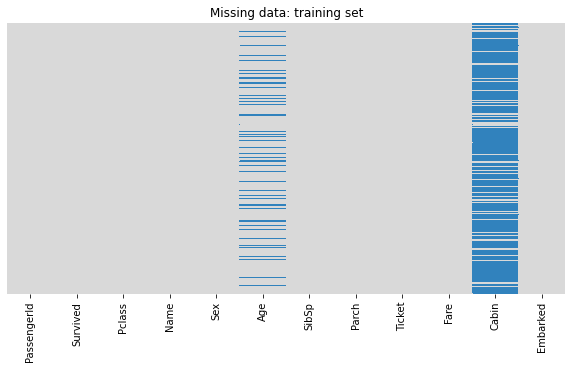

In [22]:
# Heatmap
sns.heatmap(train_data.isnull(), yticklabels = False, cbar = False, cmap = 'tab20c_r')
plt.title('Missing data: training set')
plt.show()

The 'Age' variable is missing roughly 20% of its data. This proportion is likely small enough for reasonable replacements using some form of imputation as well (using the knowledge of the other columns to fill in reasonable values).
However, too much data from the 'Cabin' column is missing to do anything useful with it at a basic level. This column may need to be dropped from the data set altogether or change to another feature such as 'Cabin Known: 1 or 0'.  

We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However, we can be smarter about this and check the average age by passenger class. 


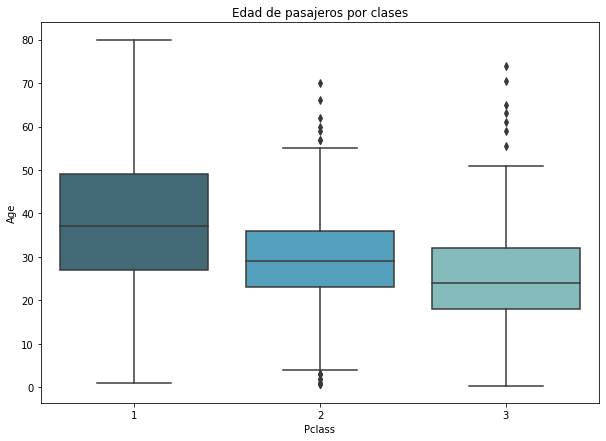

In [29]:
#Box plot
plt.figure(figsize = (10,7))
sns.boxplot(x = 'Pclass', y = 'Age', data = train_data, palette = 'GnBu_d').set_title('Edad de pasajeros por clases')
plt.show()

In [32]:
train_data.groupby(['Pclass']).Age.mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

Naturally, the wealthier passengers in the higher classes tend to be older . We'll use these average age values to impute based on Pclass for Age.


In [35]:
train_data[['Age','Pclass']]

,Age,Pclass
0,22.0,3
1,38.0,1
2,26.0,3
3,35.0,1
4,35.0,3
...,...,...
886,27.0,2
887,19.0,1
888,NaN,3
889,26.0,1


In [37]:
# Imputation function
def impute_age(cols):
    Age = cols[0]
    
    Pclass = cols[1]
    
    if pd.isnull(Age): 
        
        if Pclass == 1:
            return 38
        
        elif Pclass == 2:
            return 30
        
        else:
            return 25
    
    else: 
        return Age



    
# Apply the function to the Age column
train_data['Age'] = train_data[['Age', 'Pclass']].apply(impute_age, axis=1)

In [43]:
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


The Cabin column has too many missing values to do anything useful with, so it would be best to remove it from the data frame altogether.

In [40]:
# Remove Cabin feature
train_data.drop('Cabin', axis=1, inplace=True)

Since there is only one missing value in Embarked, that observation can just be removed.

In [42]:
# Remove rows with missing data
train_data.dropna(inplace=True)

** Data Types**  
Next, I'll need to confirm that the variables are being assigned the correct data type to allow for easier analysis later on.

**Categorical Features**

In [46]:
# Data types
print(train_data.info())

# Identify non-null objects
print('\n')

print('Objetos no nulos que convertimos a categóricos')
print(train_data.select_dtypes(['object']).columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB
None


Objetos no nulos que convertimos a categóricos
Index(['Name', 'Sex', 'Ticket', 'Embarked'], dtype='object')


Name and Ticket can be removed from the dataset as these features do not provide additional information about a passenger's liklihood of survival.    

The remaining non-null objects, Sex and Embarked, will need to be specified as categories for better analysis results downstream.  

In [47]:
# Remove unnecessary columns  
train_data.drop(['Name','Ticket'], axis = 1, inplace = True)


# Convert objects to category data type
obj_to_cat = ['Sex', 'Embarked']

for colname in obj_to_cat:
    train_data[colname] = train_data[colname].astype('category')


In [49]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  889 non-null    int64   
 1   Survived     889 non-null    int64   
 2   Pclass       889 non-null    int64   
 3   Sex          889 non-null    category
 4   Age          889 non-null    float64 
 5   SibSp        889 non-null    int64   
 6   Parch        889 non-null    int64   
 7   Fare         889 non-null    float64 
 8   Embarked     889 non-null    category
dtypes: category(2), float64(2), int64(5)
memory usage: 57.5 KB


**Numeric Features**

In [51]:
# Numeric summary
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,889.0,446.000000,256.998173,1.00,224.0000,446.0000,668.0,891.0000
Survived,889.0,0.382452,0.486260,0.00,0.0000,0.0000,1.0,1.0000
Pclass,889.0,2.311586,0.834700,1.00,2.0000,3.0000,3.0,3.0000
Age,889.0,29.218414,13.178017,0.42,22.0000,26.0000,36.5,80.0000
SibSp,889.0,0.524184,1.103705,0.00,0.0000,0.0000,1.0,8.0000
Parch,889.0,0.382452,0.806761,0.00,0.0000,0.0000,0.0,6.0000
Fare,889.0,32.096681,49.697504,0.00,7.8958,14.4542,31.0,512.3292


PassengerId can be removed from the dataset because it does not add any useful information in predicting a passenger's survival.  The remaining variables are the correct data type. 

In [52]:
# Remove PassengerId
train_data.drop('PassengerId', inplace = True, axis = 1)

## **EXPLORATORY DATA ANALYSIS**  

### **Target Variable**
'Survived' is our target as that is the dependent variable we are trying to predict.

target variable
Survived
0    549
1    340
Name: Survived, dtype: int64


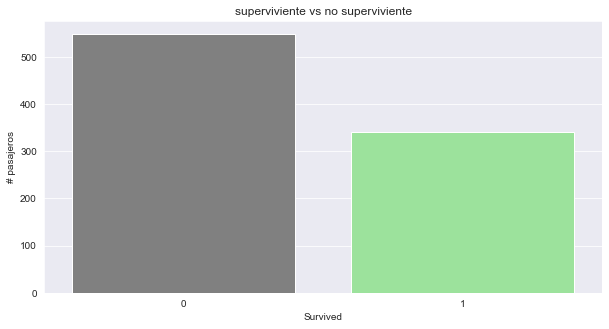

In [62]:
# Survival Count
print('target variable')
print(train_data.groupby(['Survived']).Survived.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10, 5))
sns.countplot(train_data['Survived'], palette = ['grey', 'lightgreen'])
plt.title('superviviente vs no superviviente')
plt.ylabel('# pasajeros')
plt.show()



> **Target Variable Insight**    
- The majority of passengers onboard did not survive.

### **Numeric Features**

Continuous Variables
      count       mean        std   min      25%      50%   75%       max
Age   889.0  29.218414  13.178017  0.42  22.0000  26.0000  36.5   80.0000
Fare  889.0  32.096681  49.697504  0.00   7.8958  14.4542  31.0  512.3292
--------------------------------------------------------------------------------
Discrete Variables
Pclass
1    214
2    184
3    491
Name: Pclass, dtype: int64
SibSp
0    606
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64
Parch
0    676
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64


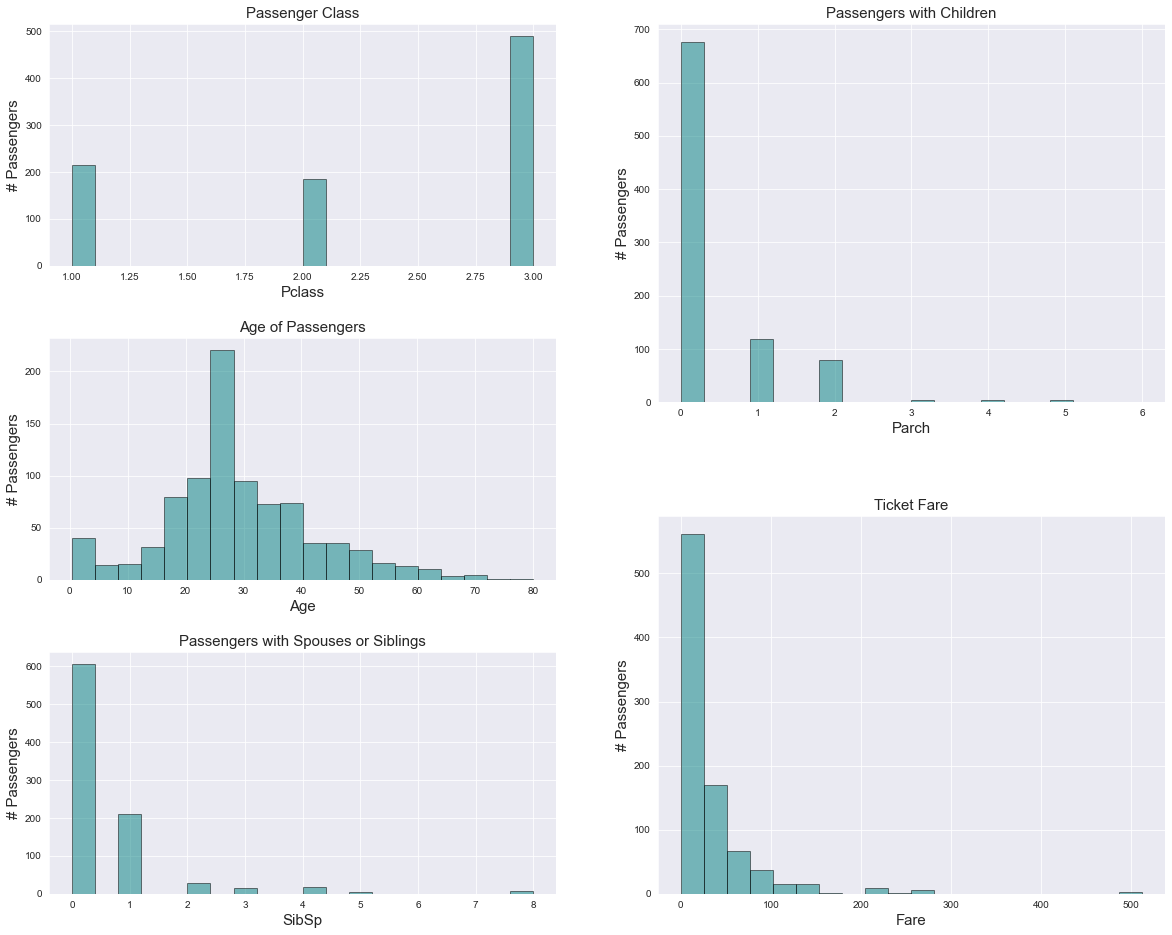

In [63]:
# Identify numeric features
print('Continuous Variables')
print(train_data[['Age','Fare']].describe().transpose())
print('--'*40)
print('Discrete Variables')
print(train_data.groupby('Pclass').Pclass.count())
print(train_data.groupby('SibSp').SibSp.count())
print(train_data.groupby('Parch').Parch.count())

# Subplots of Numeric Features
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(321)
ax1.hist(train_data['Pclass'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax1.set_xlabel('Pclass', fontsize = 15)
ax1.set_ylabel('# Passengers',fontsize = 15)
ax1.set_title('Passenger Class',fontsize = 15)

ax2 = fig.add_subplot(323)
ax2.hist(train_data['Age'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax2.set_xlabel('Age',fontsize = 15)
ax2.set_ylabel('# Passengers',fontsize = 15)
ax2.set_title('Age of Passengers',fontsize = 15)

ax3 = fig.add_subplot(325)
ax3.hist(train_data['SibSp'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax3.set_xlabel('SibSp',fontsize = 15)
ax3.set_ylabel('# Passengers',fontsize = 15)
ax3.set_title('Passengers with Spouses or Siblings',fontsize = 15)

ax4 = fig.add_subplot(222)
ax4.hist(train_data['Parch'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax4.set_xlabel('Parch',fontsize = 15)
ax4.set_ylabel('# Passengers',fontsize = 15)
ax4.set_title('Passengers with Children',fontsize = 15)

ax5 = fig.add_subplot(224)
ax5.hist(train_data['Fare'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax5.set_xlabel('Fare',fontsize = 15)
ax5.set_ylabel('# Passengers',fontsize = 15)
ax5.set_title('Ticket Fare',fontsize = 15)

plt.show()

>**Numeric Features Insights**    
- The majority of passengers aboard were third class  
- Most were single travelors with no spouses or children
- Passenger age appears to be bi-modal, with a small peak around 5 years of age and a larger peak around 25 years old.   This is an indication that the passenger age on board is distributed towards younger individuals with the median age being 26.
- The bulk of fare prices are under \$25 with a median fare of \$14.  However, the data is skewed to the right with outliers up to  \$500.  

### **Target vs Numeric Features**

### **Passenger Class**

In [13]:
# Passenger class summary



# Passenger class visualization






>**Passenger Class Insight**  
- The majority of first-class passengers survived.  
- Most of the passengers in second and third class did not survive the sinking.  


### **Passengers with Children**

>**Passengers with Children Insight**
- The majority of passengers aboard did not have children
- Most passengers without children did not survive.   
- Passengers with one or two children survived half of the time 

### **Ticket Fare and Age of Passengers**

In [15]:
train_data.hist(bins=10,figsize=(9,7),grid=False)
# Subplots of Numeric Features
sns.set_style('darkgrid')
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(train_data[train_data['Survived'] ==0].Age, bins = 25, label ='Did Not Survive', alpha = .50,edgecolor= 'black',color ='grey')
ax1.hist(train_data[train_data['Survived']==1].Age, bins = 25, label = 'Survive', alpha = .50, edgecolor = 'black',color = 'lightgreen')
ax1.set_title('Passenger Age: Survivors vs Non-Survivors')
ax1.set_xlabel('Age')
ax1.set_ylabel('# Passengers')
ax1.legend(loc = 'upper right')

ax2 = fig.add_subplot(223)
ax2.hist(train_data[train_data['Survived']==0].Fare, bins = 25, label = 'Did Not Survive', alpha = .50, edgecolor ='black', color = 'grey')
ax2.hist(train_data[train_data['Survived']==1].Fare, bins = 25, label = 'Survive', alpha = .50, edgecolor = 'black',color ='lightgreen')
ax2.set_title('Ticket Fare: Suvivors vs Non-Survivors')
ax2.set_xlabel('Fare')
ax2.set_ylabel('# Passenger')
ax2.legend(loc = 'upper right')

plt.show()

"train_data.hist(bins=10,figsize=(9,7),grid=False)\n# Subplots of Numeric Features\nsns.set_style('darkgrid')\nfig = plt.figure(figsize = (16,10))\nfig.subplots_adjust(hspace = .30)\n\nax1 = fig.add_subplot(221)\nax1.hist(train_data[train_data['Survived'] ==0].Age, bins = 25, label ='Did Not Survive', alpha = .50,edgecolor= 'black',color ='grey')\nax1.hist(train_data[train_data['Survived']==1].Age, bins = 25, label = 'Survive', alpha = .50, edgecolor = 'black',color = 'lightgreen')\nax1.set_title('Passenger Age: Survivors vs Non-Survivors')\nax1.set_xlabel('Age')\nax1.set_ylabel('# Passengers')\nax1.legend(loc = 'upper right')\n\nax2 = fig.add_subplot(223)\nax2.hist(train_data[train_data['Survived']==0].Fare, bins = 25, label = 'Did Not Survive', alpha = .50, edgecolor ='black', color = 'grey')\nax2.hist(train_data[train_data['Survived']==1].Fare, bins = 25, label = 'Survive', alpha = .50, edgecolor = 'black',color ='lightgreen')\nax2.set_title('Ticket Fare: Suvivors vs Non-Survivors')

>**Numeric Features Insight**  
- The majority of passengers under 10 years of age survived.     
- Most people that paid over \$100 for their ticket survived.  
- There were a fewer number of people that survived over the age of 40. 

### **Categorical Features**

In [16]:
# Identify categorical features


In [17]:
# Suplots of categorical features v price


# Plot [0]





# Plot [1]







>**Categorical Features Insight**
- Passengers were primarily male
- Most passengers embarked from Southhampton


### **Target vs Categorical Features**

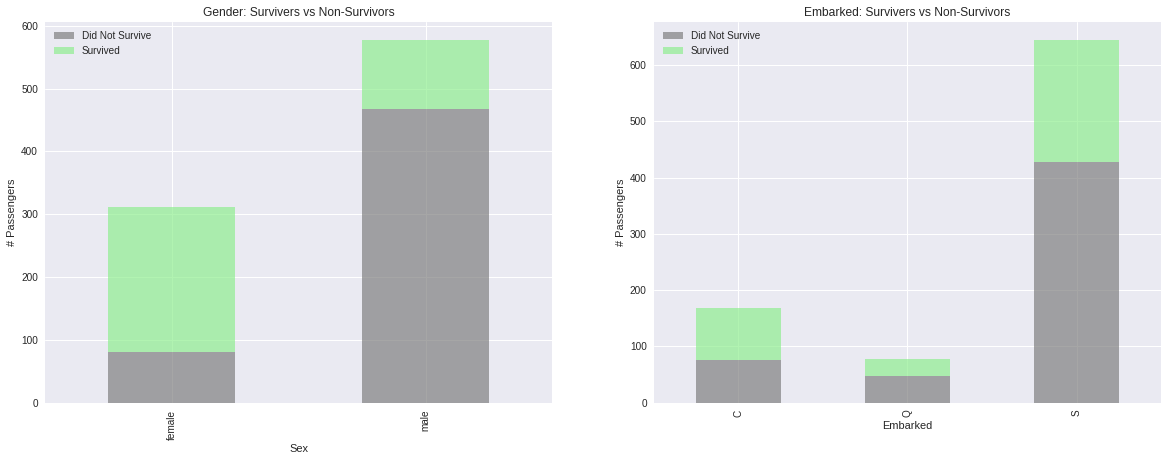

In [23]:
# Suplots of categorical features v price
sns.set_style('darkgrid')
f, axes = plt.subplots(1,2, figsize = (20,7))

gender = train_data.groupby(['Sex','Survived']).Sex.count().unstack()
p1 = gender.plot(kind = 'bar', stacked = True, 
                   title = 'Gender: Survivers vs Non-Survivors', 
                   color = ['grey','lightgreen'], alpha = .70, ax = axes[0])
p1.set_xlabel('Sex')
p1.set_ylabel('# Passengers')
p1.legend(['Did Not Survive','Survived'])


embarked = train_data.groupby(['Embarked','Survived']).Embarked.count().unstack()
p2 = embarked.plot(kind = 'bar', stacked = True, 
                    title = 'Embarked: Survivers vs Non-Survivors', 
                    color = ['grey','lightgreen'], alpha = .70, ax = axes[1])
p2.set_xlabel('Embarked')
p2.set_ylabel('# Passengers')
p2.legend(['Did Not Survive','Survived'])

plt.show()

>**Categorical Variable Insights**  
- Most of the female passengers on board survived.

### **GETTING MODEL READY**

Now that we've explored the data, it is time to get these features 'model ready'. Categorial features will need to be converted into 'dummy variables', otherwise a machine learning algorithm will not be able to take in those features as inputs.

In [24]:
# Shape of train data
train_data.shape

(889, 8)

In [25]:
# Identify categorical features
train_data.select_dtypes(['category']).columns

Index(['Sex', 'Embarked'], dtype='object')

In [26]:
# Convert categorical variables into 'dummy' or indicator variables
sex = pd.get_dummies(train_data['Sex'], drop_first = True) # drop_first prevents multi-collinearity
embarked = pd.get_dummies(train_data['Embarked'], drop_first = True)

In [27]:
# Add new dummy columns to data frame
train_data = pd.concat([train_data, sex, embarked], axis = 1)
train_data.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,male,Q,S
0,0,3,male,22.0,1,0,7.2500,S,1,0,1
1,1,1,female,38.0,1,0,71.2833,C,0,0,0


In [28]:
# Drop unecessary columns
train_data.drop(['Sex', 'Embarked'], axis = 1, inplace = True)

# Shape of train data
print('train_data shape',train_data.shape)

# Confirm changes
train_data.head()

train_data shape (889, 9)


,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1



>Now the train data is perfect for a machine learning algorithm:  
- all the data is numeric
- everything is concatenated together

## **OBJECTIVE 2: MACHINE LEARNING**
Next, I will feed these features into various classification algorithms to determine the best performance using a simple framework: **Split, Fit, Predict, Score It.**

In [29]:
# Split data to be used in the models
# Create matrix of features
x = train_data.drop('Survived', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = train_data['Survived'] # y is the column we're trying to predict

# Use x and y variables to split the training data into train and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .20, random_state = 101)

### ** LOGISTIC REGRESSION**

In [30]:
# Fit 
# Import model
from sklearn.linear_model import LogisticRegression

# Create instance of model
lreg = LogisticRegression()

# Pass training data into model
lreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
# Predict
y_pred_lreg = lreg.predict(x_test)

In [32]:
# Score It
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(y_test, y_pred_lreg) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Logistic Regression


Confusion Matrix
[[98  9]
 [26 45]]
--------------------------------------------------------------------------------
Classification Report
             precision    recall  f1-score   support

          0       0.79      0.92      0.85       107
          1       0.83      0.63      0.72        71

avg / total       0.81      0.80      0.80       178

--------------------------------------------------------------------------------
Accuracy 80.34 %
